[Theory paper](https://arxiv.org/pdf/1710.09839.pdf)
[GAIA paper](https://www.aanda.org/articles/aa/full_html/2016/11/aa29272-16/aa29272-16.html)

Note about units: The default unit for length is parsec, for mass is a solar mass, and for time is years.

In [1]:
import sympy
sympy.init_printing()
import numpy
import pylab
import time

Progress bar

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

[Salpeter initial mass function](https://en.wikipedia.org/wiki/Initial_mass_function)

In [3]:
M_star = sympy.Symbol('M_*', positive=True)
M_star_min = sympy.Symbol('M_{*min}', positive=True)
M_star_max = sympy.Symbol('M_{*max}', positive=True)
a_salpeter = sympy.Symbol('a_{salpeter}', positive=True)
C_salpeter = sympy.Symbol('C_{salpeter}', positive=True)
salpeter_imf = C_salpeter*M_star**(-a_salpeter)
salpeter_imf

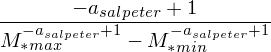

In [4]:
temp = salpeter_imf
temp = sympy.integrate(temp, M_star, conds='none')
C_salpeter_expr = sympy.solve(temp.subs(M_star, M_star_max) - temp.subs(M_star, M_star_min)-1, C_salpeter)[0]
C_salpeter_expr

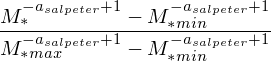

In [5]:
temp = salpeter_imf.subs(C_salpeter, C_salpeter_expr)
temp = sympy.integrate(temp, M_star, conds='none')
temp = temp - temp.subs(M_star, M_star_min)
cumulative_salpeter_imf = temp.simplify()
cumulative_salpeter_imf

What is the probability that a star is born with a mass in excess of 20 $M_{\odot}$?

In [6]:
1-cumulative_salpeter_imf.subs({
    M_star: 20,
    M_star_min:0.08,
    M_star_max:100,
    a_salpeter:2.35
})

Distribution function for masses above 20 $M_{\odot}$

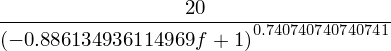

In [7]:
xi = sympy.Symbol('xi', positive=True)
f = sympy.Symbol('f', positive=True)
temp = sympy.Eq(f, cumulative_salpeter_imf)
temp = sympy.solve(temp, M_star)[0].simplify()
temp = sympy.expand_power_base(temp.subs(M_star_max, xi*M_star_min), force=True).simplify()
temp = sympy.expand_power_base(temp, force=True).simplify()
temp = temp.subs(xi, M_star_max/M_star_min)
temp.subs({a_salpeter: 2.35,
           M_star_min: 20,
           M_star_max: 100
          })

This is a simplified version of the IMFs used in the theory paper (equation 1 and 2 in theory paper)

In [8]:
def randomise_salpeter_bh_progenitor_mass(l):
    
    f = numpy.random.rand(l)
    
    return 20.0/(1.0-0.886*f)**0.741

Mass ratio (equation 3)

In [9]:
def randomise_mass_ratio(M1_list):
    
    q_min = 0.08/M1_list
    f_list = numpy.random.rand(len(M1_list))
    return q_min + f_list*(1-q_min)

Semi major axis distribution (equation 6)

In [10]:
def randomise_semi_major_axis(M1_list):
    
    f_list = numpy.random.rand(len(M1_list))
    log10A_list = 8.0*(f_list - 1)
    return 10**log10A_list

Position in the galaxy (equation 11)

In [11]:
def randomise_height_above_galactic_disc(M1_list):
    
    f_list = numpy.random.rand(len(M1_list))
    return -250*numpy.log(1-f_list)

In [12]:
def randomise_distance_from_galactic_centre(M1_list):
    
    f_list = numpy.random.rand(len(M1_list))
    return -3500*numpy.log(1-f_list)

Angle around the galactic rotation axis, relative to the line connecting the galactic centre to the sun

In [13]:
def randomise_angle_gc_sol(M1_list):
    
    return numpy.pi*numpy.random.rand(len(M1_list))

Relation between mass and radius, using the empiric relation from [Demircan and Kahraman (1991)](http://adsabs.harvard.edu/abs/1991Ap%26SS.181..313D), page 319

In [14]:
def mass2radius_demircan_kahraman(m):
    
    return 1.6*m**0.83*2.3e-8

Calculation of the ratio between the Roche lobe radius and the radius of the donor, according to the mass ratio $q$, using (equation 7)

In [15]:
def roche_lobe_radius_ratio(q):
    
    return (0.6*q**-0.67+numpy.log(1+q**-0.33))/(0.49*q**-0.67)

Terminal semi major axis for binaries with comparable masses (equation 20)

In [16]:
def calc_current_semi_major_axis_massive(q_list):
    
    return 11.18*(0.6+q_list)/(1+q_list)/(1+0.4/q_list)**3

Terminal semi major axis for binaries with large mass ratio (equation 23)

In [17]:
def calc_current_semi_major_axis_wimpy(q_list, rl_list):
    
    k = 0.2
    alpha = 1.0
    return 1.0/(2*(1-k)/(alpha*k*q_list*rl_list)+1.0/k)

Relation between progenitor and black hole mass (equation 19)

In [26]:
def calc_terminal_black_hole_mass(M1_list):
    
    return 8.0*numpy.log(M1_list - 19)/numpy.log(81.0)+2

Stellar classification

Based on [this table](http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt)

Parse table

In [18]:
with open('EEM_dwarf_UBVIJHK_colors_Teff.txt') as f:
    data = f.readlines()
table_lines = []
important_flag = False

for line in data:
    if '#SpT' in line:
        important_flag = not important_flag
        continue
    if important_flag:
        table_lines.append(line)

table_mass = []
table_vmag = []
for line in table_lines:
    mass_candidate_text = line.split()[19]
    mv_candidate_text = line.split()[4]
    if '...' in mass_candidate_text or '...' in mv_candidate_text:
        continue
    table_mass.append(float(mass_candidate_text))
    table_vmag.append(float(mv_candidate_text))
table_mass = numpy.array(table_mass)
table_vmag = numpy.array(table_vmag)

<IPython.core.display.Javascript object>


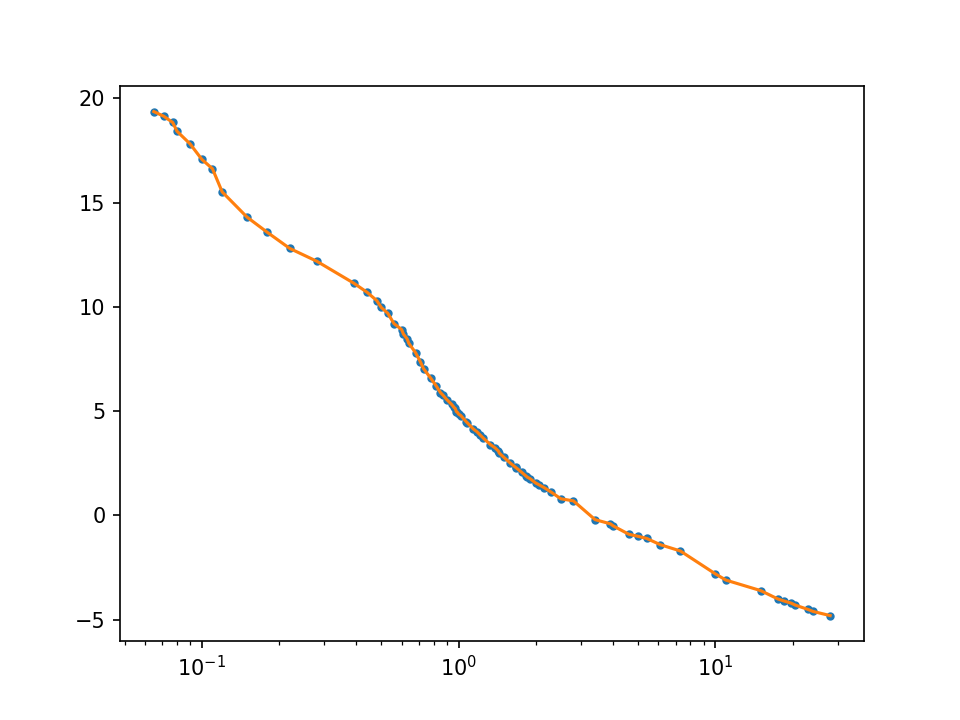

In [19]:
def stellar_mass_to_vmag(mass):
    return numpy.interp(-mass, -table_mass, table_vmag)
%matplotlib notebook
pylab.semilogx(table_mass, table_vmag,'.')
pylab.semilogx(table_mass, stellar_mass_to_vmag(table_mass));

In [20]:
def absolute_to_apparent_magnitude(absolute, d_pc, extinction=False):
    if extinction:
        return absolute+5*(numpy.log10(d_pc)-1)+d_pc/1e3
    return absolute+5*(numpy.log10(d_pc)-1)

Gaia Sensitivity (section 8 in Gaia paper)

In [21]:
def calc_gaia_z12p09(gmag):
    
    capped_gmag = numpy.clip(gmag, 12, 200)
    return numpy.clip(10**(0.4*(capped_gmag-15)),10**(0.4*(12.09-15)),1e30)

def calc_sigma_pomega(gmag):
    
    z = calc_gaia_z12p09(gmag)
    return numpy.sqrt(-1.63+680.8*z+32.7*z**2)

def calc_sigma_G(gmag):
    
    z = calc_gaia_z12p09(gmag)
    return 1.2e-3*numpy.sqrt(0.05*z**2+1.9*z+0.0002)

Synthetic stellar population

In [59]:
ssp = {'primary mass':randomise_salpeter_bh_progenitor_mass(int(1e6))}
ssp['initial mass ratio'] = randomise_mass_ratio(ssp['primary mass'])
ssp['companion mass'] = ssp['primary mass']*ssp['initial mass ratio']
ssp['initial semi major axis'] = randomise_semi_major_axis(ssp['primary mass'])
ssp['z'] = randomise_height_above_galactic_disc(ssp['primary mass'])
ssp['r'] = randomise_distance_from_galactic_centre(ssp['primary mass'])
ssp['angle'] = randomise_angle_gc_sol(ssp['primary mass'])
ssp['black hole mass'] = calc_terminal_black_hole_mass(ssp['primary mass'])
ssp['terminal mass ratio'] = ssp['black hole mass']/ssp['companion mass']
ssp['age'] = numpy.random.rand(len(ssp['primary mass'])) # Age / galactic age
ssp['lifetime'] = ssp['companion mass']**-2.5 - ssp['primary mass']**-2.5 # Normalised by the age of the galaxy
ssp['companion mass'] = ssp['primary mass']*ssp['initial mass ratio']
ssp['companion radius'] = mass2radius_demircan_kahraman(ssp['companion mass'])
ssp['initial primary radius'] = mass2radius_demircan_kahraman(ssp['primary mass'])
ssp['initial roche radius'] = roche_lobe_radius_ratio(ssp['initial mass ratio'])*ssp['initial primary radius']
ssp['terminal roche radius'] = roche_lobe_radius_ratio(1.0/ssp['terminal mass ratio'])*ssp['companion radius']
ssp['terminal semi major axis'] = numpy.where(ssp['initial mass ratio'] > 0.5,
                                              calc_current_semi_major_axis_massive(ssp['initial mass ratio']),
                                              calc_current_semi_major_axis_wimpy(ssp['initial mass ratio'],
                                                                                ssp['initial roche radius']/
                                                                                 ssp['initial semi major axis']))
ssp['terminal period'] = 9.4e7*(ssp['terminal semi major axis']**1.5*
                                ssp['primary mass']**-0.5*
                                (0.2+ssp['initial mass ratio'])**-0.5)
ssp['companion absolute magnitude'] = stellar_mass_to_vmag(ssp['primary mass']*ssp['initial mass ratio'])
ssp['distance from earth'] = numpy.sqrt(ssp['z']**2+8000**2+ssp['r']**2-2*8000*ssp['r']*numpy.cos(ssp['angle']))
ssp['companion apparent magnitude'] = absolute_to_apparent_magnitude(ssp['companion absolute magnitude'],
                                                                     ssp['distance from earth'],
                                                                    extinction=True)
ssp['sigma pomega'] = calc_sigma_pomega(ssp['companion apparent magnitude'])
ssp['parallax'] = 1e6/ssp['distance from earth'] # in uas
ssp['sigma G'] = calc_sigma_G(ssp['companion apparent magnitude'])

Count how many will be visible by Gaia

In [60]:
valid_list = ssp['lifetime'] > ssp['age']
print(valid_list.sum())
valid_list = numpy.logical_and(valid_list,
                              ssp['terminal semi major axis']>ssp['terminal roche radius'])
print(valid_list.sum())
valid_list = numpy.logical_and(valid_list,
                              ssp['terminal period']<5)
print(valid_list.sum())
valid_list = numpy.logical_and(valid_list,
                              ssp['terminal period']>0.137)
print(valid_list.sum())
valid_list = numpy.logical_and(valid_list,
                              ssp['black hole mass']>3.0/(1.0-ssp['sigma pomega']/ssp['parallax']-ssp['sigma G']-ssp['sigma pomega']*ssp['distance from earth']/2e11/ssp['terminal semi major axis']))
print(valid_list.sum())
valid_list = numpy.logical_and(valid_list,
                              ssp['companion apparent magnitude']<20)
print(valid_list.sum())
valid_list = numpy.logical_and(valid_list,
                              ssp['terminal semi major axis']>
                               10*(1+ssp['initial mass ratio']/0.2)*ssp['sigma pomega']*ssp['distance from earth']*5e-12)
valid_list.sum()

50131
42249
16635
6643
6602
160


29

Statistics of detected black holes - luminous companion binaries

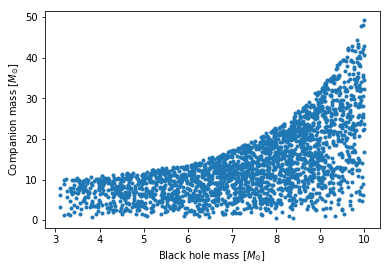

In [54]:
%matplotlib inline
pylab.plot(ssp['black hole mass'][valid_list],
          ssp['companion mass'][valid_list], '.')
pylab.xlabel('Black hole mass [$M_{\odot}$]')
pylab.ylabel('Companion mass [$M_{\odot}$]');

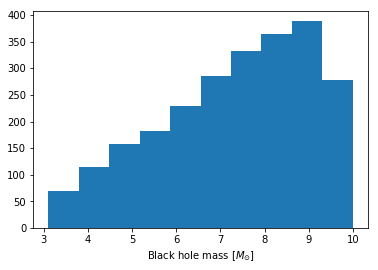

In [55]:
%matplotlib inline
pylab.hist(ssp['black hole mass'][valid_list])
pylab.xlabel('Black hole mass [$M_{\odot}$]');

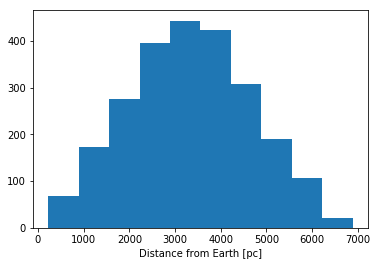

In [56]:
%matplotlib inline
pylab.hist(ssp['distance from earth'][valid_list])
pylab.xlabel('Distance from Earth [pc]');